In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
sns.set_style('darkgrid')

In [60]:
nodes_df = pd.read_csv('nodes.csv')
weighted_edges_df = pd.read_csv('edges.csv')

In [61]:
nodes_df.loc[nodes_df['ruolo'].str.contains('Politico'), 'ruolo'] = 'Cittadino'
nodes_df.loc[nodes_df['ruolo'].str.contains('Agenzia Delle Dogane'), 'ruolo'] = 'Cittadino'
nodes_df.loc[nodes_df['ruolo'].str.contains('Membro Provincia'), 'ruolo'] = 'Affiliato'
nodes_df.loc[nodes_df['ruolo'].str.contains('Ex-capo'), 'ruolo'] = 'Capo'
nodes_df.loc[nodes_df['ruolo'].str.contains('Vicario/Contabile'), 'ruolo'] = 'Vicario'

In [62]:
G = nx.Graph()

for i, index in enumerate(nodes_df.index.values):
    G.add_node(int(index),name = nodes_df.loc[i, 'name'],family_size= nodes_df.loc[i, 'family_size'], family_name = nodes_df.loc[i, 'surname'], locale = nodes_df.loc[i, 'locale'], ruolo = nodes_df.loc[i, 'ruolo'],locale_id = nodes_df.loc[i, 'locale_id'])
    
for i, row in weighted_edges_df.iterrows():
    G.add_edge(int(row['source']), int(row['target']), weight = int(row['weight']))

In [64]:
from networkx.algorithms.community import greedy_modularity_communities
c_degree = nx.degree_centrality(G)
c_degree = list(c_degree.values())
c = list(greedy_modularity_communities(G))

nb_nodes = len(list(G.nodes()))
nb_edges = len(list(G.edges()))
degrees = list(dict(G.degree()).values())
avg_degree = np.mean(degrees)
median_degree = np.median(degrees)
max_degree = np.max(degrees)        
min_degree = np.min(degrees) 
avg_centrality = np.mean(c_degree) 
min_centrality = np.min(c_degree) 
max_centrality = np.max(c_degree) 
median_centrality = np.median(c_degree) 
print("Number of nodes: ", nb_nodes)
print("Number of edges: ", nb_edges)
print("Average degree: ", avg_degree)
print("Median degree: ", median_degree)
print("Max degree: ", max_degree)
print("Min degree: ", min_degree)
print("Average centrality: ", avg_centrality)
print("Median centrality: ", median_centrality)
print("Max centrality: ", max_centrality)
print("Min centrality: ", min_centrality)
print("Mean of the weighted edges: ", weighted_edges_df['weight'].mean())

Number of nodes:  139
Number of edges:  1470
Average degree:  21.151079136690647
Median degree:  16.0
Max degree:  72
Min degree:  4
Average centrality:  0.15326868939630905
Median centrality:  0.11594202898550725
Max centrality:  0.5217391304347826
Min centrality:  0.028985507246376812


### FINDING THE KINGPINS IN THE NETWORK

**FIRST INDICATOR - DEGREE DISTRIBUTION**

- There are several metrics that might help us establish who the most important players are in this network.
- The first is the number of degrees or connections that each node/mafiosi has.
- When we plot this, we can see that most of the mobsters have less than twenty connections, while a handful have several times this amount.


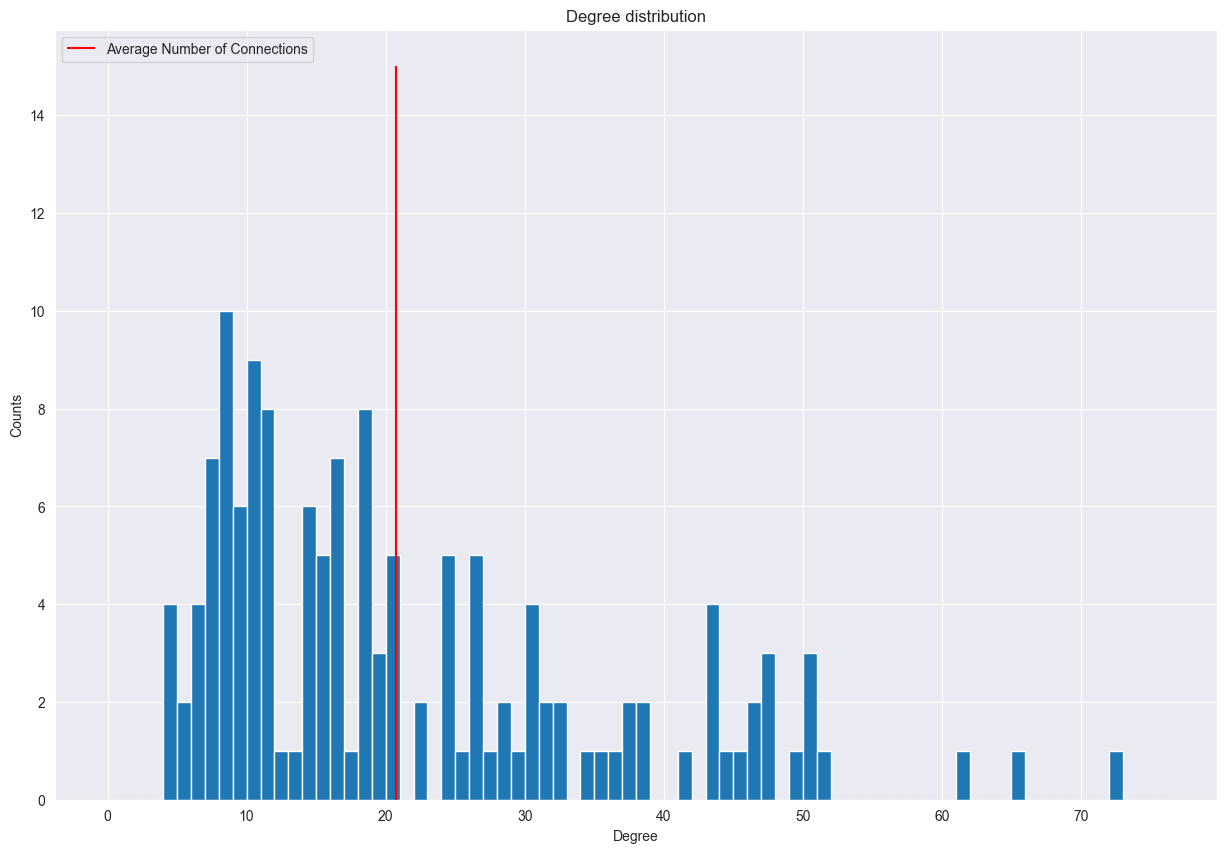

In [ ]:
# On average each mafioso has 21 connections within the extended group, but six have fifty or more connections

fig, ax = plt.subplots(figsize = (15,10))
plt.hist([list(dict(G.degree()).values())],
         bins = np.linspace(0, 76, 77), stacked = False)
plt.vlines(20.7564, 0, 15, color = 'red')
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.legend(['Average Number of Connections'], prop={'size': 10},
           loc='upper left')
plt.title('Degree distribution')
plt.savefig('degree_histogram.png')

**SECOND INDICATOR - CLUSTERING COEFFICIENTS**

- The clustering coefficient measures the extent to which the nodes tend to cluster together. 
- If a mafiosi's close associates are all linked, then he will have a high clustering coefficient.
- A better connected node will often have a lower clustering coefficient, as having many connections makes it less likely that all the connections will be linked to each other.
- When we plot the distribution of the clustering coefficients, we'll see that most nodes have a high coefficient. 
- However a few of them do not, and these guys might have significance within the network. 

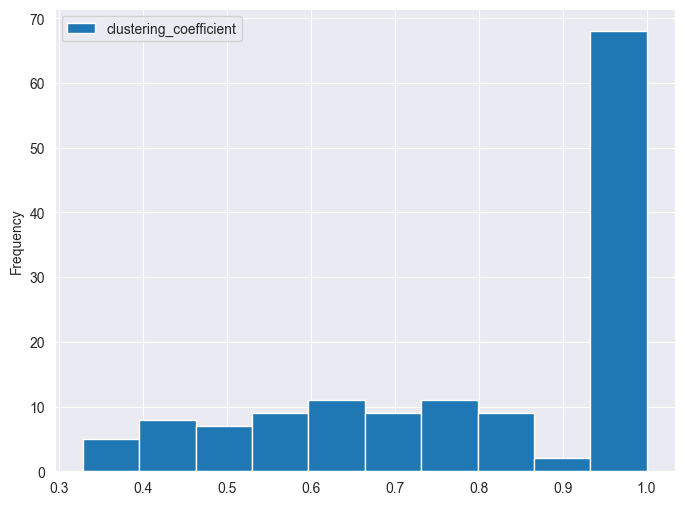

In [ ]:
# form dataframe out of the clustering coefficients for each mafiosi
#visualise the distribution of the clustering coefficients
#most nodes have a high clustering coefficient
#it would be interesting to look at the few guys with the lower clustering coefficients

clustering = nx.clustering(G)
clustering_df = pd.DataFrame(clustering, columns = clustering.keys(), index = range(1))
clustering_df = clustering_df.T.rename(columns = {0: 'clustering_coefficient'})
fig, ax = plt.subplots(figsize = (8, 6))
clustering_df.plot(kind = 'hist', ax = ax)
plt.savefig('clustering.png')

**THIRD INDICATOR - NODE CENTRALITY**

- It is striking that the same six names have emerged from the degree distribution and the clustering coefficients. It looks like they are all connected to many other mafiosi, who in turn are not all connected to each other. These six are the major hubs.
- Another indicator to consider is how central each node is, as expressed by 'Betweenness Centrality'. This looks at how many of the 'shortest paths' between other nodes pass through a particular node.
- When we plot the distribution of 'Betweenness Centrality' for the network, we find that most mafiosi score low on this metric.
- A few mafiosi have high scores, and are likely to be influential.

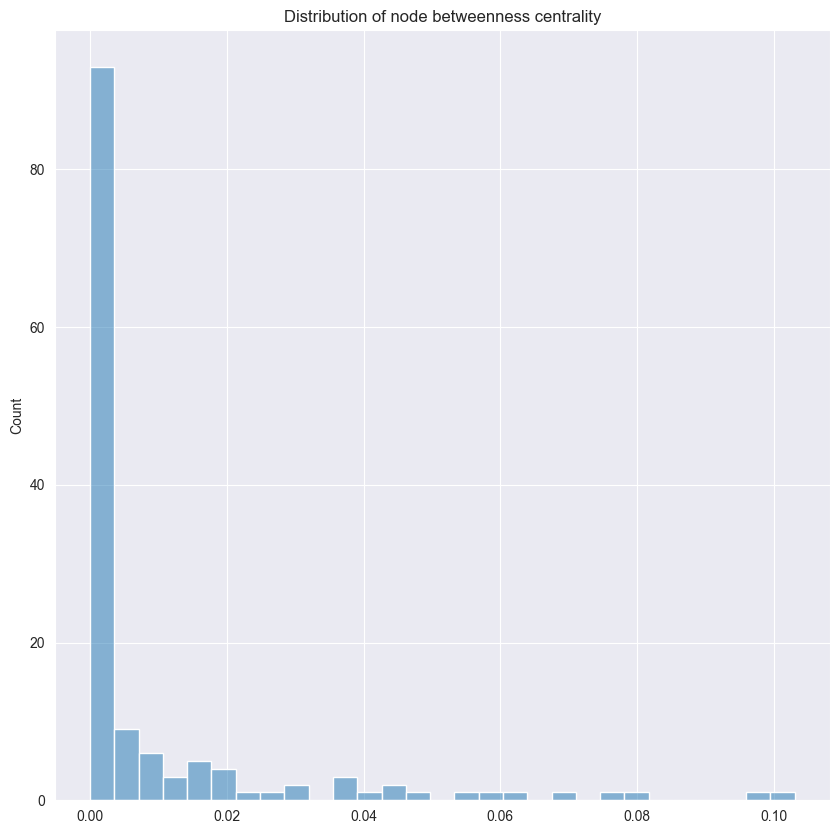

In [ ]:
#visualise the distribution of 'Betweenness Centrality' in the network

node_centrality = nx.betweenness_centrality(G)
fig, ax = plt.subplots(figsize = (10,10))
sns.histplot(node_centrality.values(), ax = ax, legend = False)
plt.title('Distribution of node betweenness centrality')
plt.savefig('betweenness.png')

**EXAMINE EDGES AS WELL AS NODES**
- We've looked at the nodes, now it would be intersting to see which edges are the most important. 
- There are a couple of metrics that we can consider: Edge Weights indicate how many times a particular connection has been made, and 'Edge Betweenness Centrality' is analogous to 'Node Betweenness Centrality', indicating the percentage of shortest paths that pass though a specific edge.


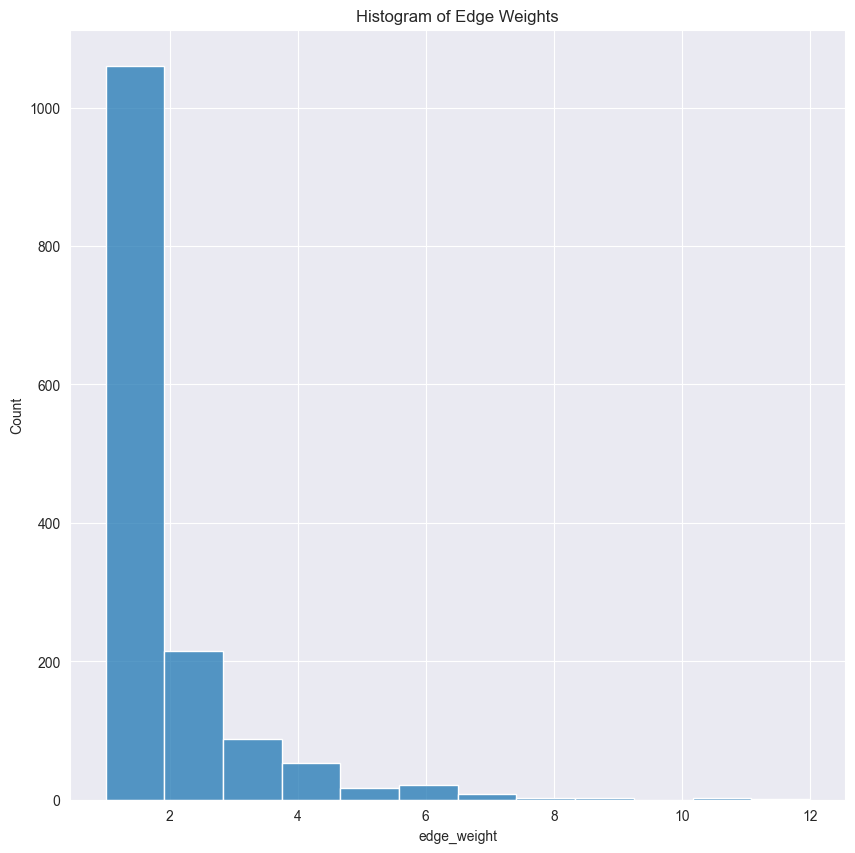

In [ ]:
# visualise the distribution of edge weights throughout the network

edge_weights = [e[2]['weight'] for e in G.edges(data=True)]
fig, ax = plt.subplots(figsize = (10,10))
sns.histplot(edge_weights, ax = ax, bins = 12)
plt.xlabel('edge_weight')
plt.title('Histogram of Edge Weights')
plt.show()

In [73]:
import nx_altair as nxa
chart = nxa.draw_networkx(
    G=G,
    pos=nx.spring_layout(G),
    width='weight:N',
    node_color='ruolo:N',
    cmap = "Category10",
    node_tooltip=['name','locale','ruolo'],

)

edges = chart.layer[0].properties(height=1400, width=1400)
nodes = chart.layer[1].properties(height=1400, width=1400)

nodes = nodes.encode(
    #fill='locale:N',
    #color='locale:N'
).properties(
    height=2000, width=2000, title="Ruolo"
)

central = (edges+nodes).interactive()

central

alt.LayerChart(...)

In [74]:
nodes_df['ruolo'].value_counts()

Affiliato        103
Capo              21
Vicario            6
Contabile          5
Cittadino          3
Capo Generale      1
Name: ruolo, dtype: int64

In [10]:
import array
import copy
import operator

toremove = array.array('i', [])
nrem = 5
names = ['id', 'data']
formats = ['int32', 'int32']
dtype = dict(names=names, formats=formats)

In [11]:
def collective_influence_centality(Graph, torem, weight=None):
    colinf = dict()
    for node in Graph:
        summatory = 0
        for iter_node in Graph.neighbors(node):
            if weight is None:
                summatory += Graph.degree(iter_node) - 1
            else:
                summatory += Graph.degree(iter_node, weight='weight') - 1
        if weight is None:
            colinf[node] = (Graph.degree(node) - 1) * summatory
        else:
            colinf[node] = (Graph.degree(node, weight='weight') - 1) * summatory
    npcolinf = np.fromiter(colinf.items(), dtype=dtype, count=len(colinf))
    sorted_colinf = np.sort(npcolinf, order='data')
    for rem_n in range(1, nrem + 1):
        # To populate the array of the nodes to be removed (the nrem ones with the highest centrality score).
        torem.append(sorted_colinf[-rem_n][0])  # Sorted in descreasing order.
    return torem



def lcc_size(Graph):
    """
    Compute Largest Connected Component (LCC) in a Graph.
    """
    compsize = []
    for c in nx.connected_components(Graph):
        compsize.append(nx.number_of_nodes(Graph.subgraph(c)))
    return max(compsize)


def max_centr(Graph, centrality_function, torem, weight=None):
    """
    Nodes sorting (as dict, key:node_name, value:centrality_score) according to the centrality function.
    """
    if weight is None:
        dcentr = centrality_function(Graph)
    else:

        dcentr = centrality_function(Graph, weight='weight')

    sorted_x = sorted(dcentr.items(), key=operator.itemgetter(1))
    for rem_n in range(1, nrem + 1):
        torem.append(sorted_x[-rem_n][0])
    return torem


def disruption(Graph, centrality_function, centrality_label,
               lccinit, dflcc, dflccvar, dfdegreecentr, casekey, weight=None):
    """
    Network Disruption. Compute Largest Connected Component (LCC) and Collective Influence (CI) after nodes removal.
    :return dflcc: (pandas.core.frame.DataFrame) LCC Dataframe.
    (Dataframe will be composed by: Iter_Num, LCC size after node removal according to the Centrality_Metrics).
    :return dflccvar: (pandas.core.frame.DataFrame) LCC size variation compared with the initial LCC Dataframe.
    (Dataframe will be composed by: Iter_Num, LCC size after node removal according to the Centrality_Metrics).
    """
    dictx = dict()  # Dict current LCC size
    dicty = dict()  # Dict current LCC normalized percentage variation compared with the initial LCC
    degree_x= dict()  # Dict current Degree
    kiter = 0
    toremove = array.array('i', [])
    while Graph.number_of_nodes() > nrem:
        # The while-loop stops when there are no enough nodes in the Graph to be removed.
        i = 0
        if casekey == 2:  # BLOCK
            toremove = array.array('i', [])
            # BLOCK case:
            # Step1: Compute LCC size and Centralities scores,
            # Step2: Create an array of N nodes with the highest score (to be removed)
            # Step3: Back to Step1.
            # NB: The next node's score (in nrem nodes to be removed at once) WILL NOTE BE affected.
            degree_x[kiter] = 2*Graph.number_of_edges() / Graph.number_of_nodes()
            dictx[kiter] = lcc_size(Graph)
            dicty[kiter] = 1 - (abs((lcc_size(Graph) - lccinit) / lccinit))
            if centrality_label == 'Collective Influence':
                toremove = collective_influence_centality(Graph, toremove, weight=weight)
            elif centrality_label != 'Collective Influence':
                toremove = max_centr(Graph, centrality_function, toremove, weight=weight)

        while i < nrem:
            if Graph.number_of_nodes() <= nrem:
                break
            if casekey == 1:  # SEQUENTIAL
                toremove = array.array('i', [])
                # SEQUENTIAL case:
                # Step1: Compute LCC size and Centralities scores,
                # Step2: Create an array of N nodes with the highest score (to be removed)
                # Step3: Back to Step1.
                # NB: The next node's score (in nrem nodes to be removed at once) WILL BE affected.
                dictx[kiter] = lcc_size(Graph)
                degree_x[kiter] = 2* Graph.number_of_edges() / Graph.number_of_nodes()
                dicty[kiter] = 1 - (abs((lcc_size(Graph) - lccinit) / lccinit))
                if centrality_label == 'Collective Influence':
                    toremove = collective_influence_centality(Graph, toremove, weight=weight)
                elif centrality_label != 'Collective Influence':
                    toremove = max_centr(Graph, centrality_function, toremove, weight=weight)
            Graph.remove_node(toremove[0])
            toremove.pop(0)
            kiter += 1
            i += 1
    dfdegreecentr['No'] = list(degree_x.keys())
    dfdegreecentr[centrality_label] = list(degree_x.values())
    dflcc['No'] = list(dictx.keys())
    dflccvar['No'] = dflcc['No']
    dflcc[centrality_label] = list(dictx.values())
    dflccvar[centrality_label] = list(dicty.values())
    return dflcc, dflccvar, dfdegreecentr


def degree_centrality_w(Graph, weight=None):
    """Compute the degree centrality for nodes. From NetworkX, but adapted for weighted graphs.
    The degree centrality for a node v is the fraction of nodes it is connected to.
    """
    if len(Graph) <= 1:
        return {nn: 1 for nn in Graph}

    s = 1.0 / (len(Graph) - 1.0)
    # New implementation:
    if weight is None:
        centrality = {nn: d * s for nn, d in Graph.degree()}
    else:
        centrality = {nn: d * s for nn, d in Graph.degree(weight='weight')}
    return centrality

def closs_centrality_w(Graph, weight=None):
    """Compute the closeness centrality for nodes. From NetworkX, but adapted for weighted graphs."""
    closs = nx.closeness_centrality(Graph)
    closs_weighted = nx.closeness_centrality(Graph, distance='weight')
    if weight is None:
        centrality = {nn: closs[nn] for nn in Graph}
    else:
        centrality = {nn: closs_weighted[nn] for nn in Graph}
    return centrality

def capo_locale_centrality_w(Graph, weight=None):

    between= nx.betweenness_centrality(Graph)
    between_weighted = nx.betweenness_centrality(Graph, weight='weight')
    closs= nx.closeness_centrality(Graph)
    closs_weighted = nx.closeness_centrality(Graph, distance='weight')
    if len(Graph) <= 1:
        return {nn: 1 for nn in Graph}

    #create a dictonary ordered with nodes with "ruolo" capo a value 1 and others 0
    
    s = 1.0 / (len(Graph) - 1.0)
    # New implementation:
    if weight is None:
        centrality = {nn: np.sqrt(np.power(between[nn],2) + np.power(closs[nn],2)) + (1 if Graph.nodes[nn]['ruolo'] == 'Capo' else 0)+(1 if Graph.nodes[nn]['ruolo'] == 'Capo Generale' else 0) for nn in Graph}
    else:
         centrality = {nn: np.sqrt(np.power(between_weighted[nn],2) + np.power(closs_weighted[nn],2)) + (1 if Graph.nodes[nn]['ruolo'] == 'Capo' else 0)+(1 if Graph.nodes[nn]['ruolo'] == 'Capo Generale' else 0) for nn in Graph}

    return centrality

def vicario_centrality_w(Graph, weight=None):
    between= nx.betweenness_centrality(Graph)
    between_weighted = nx.betweenness_centrality(Graph, weight='weight')
    closs= nx.closeness_centrality(Graph)
    closs_weighted = nx.closeness_centrality(Graph, distance='weight')
    if len(Graph) <= 1:
        return {nn: 1 for nn in Graph}

    #create a dictonary ordered with nodes with "ruolo" capo a value 1 and others 0
    
    s = 1.0 / (len(Graph) - 1.0)
    # New implementation:
    if weight is None:
        centrality = {nn: np.sqrt(np.power(between[nn],2) + np.power(closs[nn],2)) + (1 if Graph.nodes[nn]['ruolo'] == 'Vicario' else 0)+(1 if Graph.nodes[nn]['ruolo'] == 'Contabile' else 0) for nn in Graph}
    else:
         centrality = {nn: np.sqrt(np.power(between_weighted[nn],2) + np.power(closs_weighted[nn],2)) + (1 if Graph.nodes[nn]['ruolo'] == 'Vicario' else 0)+(1 if Graph.nodes[nn]['ruolo'] == 'Contabile' else 0) for nn in Graph}

    return centrality

def mix_centrality_w(Graph, weight=None):

    between= nx.betweenness_centrality(Graph)
    between_weighted = nx.betweenness_centrality(Graph, weight='weight')
    closs= nx.closeness_centrality(Graph)
    closs_weighted = nx.closeness_centrality(Graph, distance='weight')
    if len(Graph) <= 1:
        return {nn: 1 for nn in Graph}

    #create a dictonary ordered with nodes with "ruolo" capo a value 1 and others 0

    s = 1.0 / (len(Graph) - 1.0)
    # New implementation:
    if weight is None:
        centrality = {nn: np.sqrt(np.power(between[nn],2) + np.power(closs[nn],2)) + (1 if Graph.nodes[nn]['ruolo'] == 'Vicario' else 0)+(1 if Graph.nodes[nn]['ruolo'] == 'Contabile' else 0) + (0.5 if Graph.nodes[nn]['ruolo'] == 'Capo' else 0)+(0.4 if Graph.nodes[nn]['ruolo'] == 'Capo Generale' else 0) for nn, d in Graph.degree()}
    else:
        centrality = {nn:(between_weighted[nn]) + (closs_weighted[nn]) + (1 if Graph.nodes[nn]['ruolo'] == 'Vicario' else 0)+(1 if Graph.nodes[nn]['ruolo'] == 'Contabile' else 0) + (0.5 if Graph.nodes[nn]['ruolo'] == 'Capo' else 0)+(0.4 if Graph.nodes[nn]['ruolo'] == 'Capo Generale' else 0) for nn, d in Graph.degree(weight='weight')}
    return centrality

def mix_centrality_betw_closs(Graph, weight=None):

    between= nx.betweenness_centrality(Graph)
    between_weighted = nx.betweenness_centrality(Graph, weight='weight')
    closs= nx.closeness_centrality(Graph)
    closs_weighted = nx.closeness_centrality(Graph, distance='weight')
    if len(Graph) <= 1:
        return {nn: 1 for nn in Graph}

    if weight is None:
        centrality = {nn: np.sqrt(np.power(between[nn],2) + np.power(closs[nn],2)) for nn in Graph}
    else:
        centrality = {nn: np.sqrt(np.power(between_weighted[nn],2) + np.power(closs_weighted[nn],2)) for nn in Graph}
    return centrality
   

In [12]:
print(G.nodes[8])

{'name': 'BARRANCA Cosimo', 'family_size': 5, 'family_name': 'BARRANCA', 'locale': 'Milano', 'ruolo': 'Capo', 'locale_id': 11}


In [18]:
nrem=5 #number of nodes to remove
Gor = copy.deepcopy(G)
#
# Disruption
#
name = {'Mafia_Summit': 'Meeting'}
lcc_init = lcc_size(G)  # Original LCC
cases = {1: 'Sequential', 2: 'Block'}
w_enable = [None, 'weight']

f = {
    'Degree': degree_centrality_w,
    'Collective Influence': collective_influence_centality,
    'Betweenness': nx.betweenness_centrality,
    'Closeness': closs_centrality_w,
    'Capo': capo_locale_centrality_w,
    "Vicario + Contabile": vicario_centrality_w,
     #"Betw + Closs + Ruoli": mix_centrality_w, # Betw + Closs + Ruoli
    #'CapoLocale': capo_locale_centrality_w,
    #"Betw + Closs": mix_centrality_betw_closs,
}
# NB: Use nx.katz_centrality_numpy instead of nx.katz_centrality otherwise PowerIterationFailedConvergence rise
for ww in w_enable:  # Iterate between weighted (string) and unweighted (None, by default) versions.
    for k, v in cases.items():  # Iterate between Sequential and Block nodes removal.
        df_lcc = pd.DataFrame()
        df_lcc_var = pd.DataFrame()
        df_degree_centr = pd.DataFrame()
        for colname, function in f.items():  # Iterate the centrality metrics to be used.
            df_lcc, df_lcc_var,degree_centr = disruption(copy.deepcopy(Gor), function, colname, lcc_init,
                                            df_lcc, df_lcc_var,df_degree_centr, k, ww)
        #
        # Exporting Results
        #
        if ww is None:
            w_en = 'Unweighted'
        else:
            w_en = 'Weighted'
        #degree_centr.to_csv('Results/{0}/{1}/df_{2}_{3}nremDegree.csv'.format(v, 'Meeting', w_en, nrem))
        df_lcc_var.to_csv('Results/{0}/{1}/df_{2}_{3}nrem.csv'.format(v, 'Meeting', w_en, nrem))
        # To plot the results, please run network-disruption-plots.py

In [6]:
def plot_creation(tosave, dflcc, typerem, input_name, w):
    """
    Network Disruption Plot
    """
    colnames = list(dflcc.columns)
    # Uncomment below to test what it is plotting by putting a title on the plot itself. If so, change function inputs.
    #plt.title(r" {0} Dataset: {1}, {2} Removals, nrem:{3} ".format(files_name[files_key], w, typerem, nrem),
    #          fontsize=22, color='gray')
    sns.set_style("white")
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['legend.title_fontsize'] = '24'
    #plt.rcParams["axes.labelweight"] = "bold"

    xlabel = colnames[1]
    idx1 = (list(range(0, 20, 5)))  # per vedere in dettaglio i valori iniziali
    idx2 = (list(range(20, (int(df["No"].tail(1))), 10)))  # per fissare a priori le ascisse con valori interi
    idx = idx1 + idx2
    #idx.append(int(df["No"].tail(1)))  # per stampare anche l'ultimo valore
    plt.grid(True, linestyle=':')
    for ylab in colnames[2:]:
        ax = sns.lineplot(x=xlabel, y=ylab, markers=True, dashes=False, data=dflcc, label=ylab, lw=2)
    
        #ax = sns.lineplot(x=xlabel, y=ylab, markers=True, dashes=False, data=dflcc, label=ylab, lw=4, marker="o")
    # noinspection PyUnboundLocalVariable
    ax.set_xticks(idx)
    ax.set_xlabel(r'$i$', fontsize=24)
    ax.set_ylabel(r'$\rho_i$', fontsize=24)
    ax.legend(title="Propietà",fontsize=24)  # , prop=legend_properties)
    ax.legend(title="Human Capital",fontsize=24)  # , prop=legend_properties)
    ax.tick_params(labelsize=24)
    # Uncomment below for a detailed plot of first 30 iterations, discarding the others.
    ax.set(xlim=(0, 40))
    ax.set(ylim=(0.06, 1))
    fig = plt.gcf()
    fig.set_size_inches((15, 13), forward=False)
    fig.savefig(tosave + '{0}_{1}_{2}-plos-short.png'.format(input_name, typerem, w, nrem),
                dpi=600, format='png')
    fig.clf()
   



In [7]:
nrem=5
w_enable = [None, 'weight']
cases = {1: 'Sequential', 2: 'Block'}
name ='Meeting'
for ww in w_enable:
    for k, v in cases.items():
        if ww is None:
            w_en = 'Unweighted'
        else:
            w_en = 'Weighted'
        path = ('Results/{0}/{1}/'.format(v, name))
        df = pd.read_csv(path + 'df_{0}_{1}nrem.csv'.format(w_en, nrem))
        plot_creation(path, df, v, name, w_en)

<Figure size 1500x1300 with 0 Axes>

In [25]:
df_Weighted_5nrem = pd.read_csv('Results/Block/Meeting/df_Weighted_5nrem.csv')
df_Unweighted_5nrem = pd.read_csv('Results/Block/Meeting/df_Unweighted_5nrem.csv')
df_Weighted_seq = pd.read_csv('Results/Sequential/Meeting/df_Weighted_5nrem.csv')
df_Unweighted_seq = pd.read_csv('Results/Sequential/Meeting/df_Unweighted_5nrem.csv')

In [50]:
#print the first index where the value of Betweeneess is less than 0.06 in dataframe df_Weighted_5nrem
print("Betweenness" , df_Weighted_5nrem[df_Weighted_5nrem['Betweenness'] < 0.06].index[0])
print("Collective Influence" ,df_Weighted_5nrem[df_Weighted_5nrem['Collective Influence'] < 0.06].index[0])
print("Degree" ,df_Weighted_5nrem[df_Weighted_5nrem['Degree'] < 0.06].index[0])
print("CapoLocale" ,df_Weighted_5nrem[df_Weighted_5nrem['CapoLocale'] < 0.06].index[0])
print("Vicario" ,df_Weighted_5nrem[df_Weighted_5nrem['Vicario'] < 0.06].index[0])


Betweenness 12
Collective Influence 15
Degree 16
CapoLocale 15
Vicario 16


In [51]:
#print the first index where the value of Betweeneess is less than 0.06 in dataframe df_Weighted_5nrem
print("Betweenness" , df_Unweighted_5nrem[df_Unweighted_5nrem['Betweenness'] < 0.06].index[0])
print("Collective Influence" ,df_Unweighted_5nrem[df_Unweighted_5nrem['Collective Influence'] < 0.06].index[0])
print("Degree" ,df_Unweighted_5nrem[df_Unweighted_5nrem['Degree'] < 0.06].index[0])
print("CapoLocale" ,df_Unweighted_5nrem[df_Unweighted_5nrem['CapoLocale'] < 0.06].index[0])
print("Vicario" ,df_Unweighted_5nrem[df_Unweighted_5nrem['Vicario'] < 0.06].index[0])


Betweenness 13
Collective Influence 16
Degree 14
CapoLocale 15
Vicario 15


In [46]:
print("Betweenness" , df_Weighted_seq[df_Weighted_seq['Betweenness'] < 0.06].index[0])
print("Collective Influence" ,df_Weighted_seq[df_Weighted_seq['Collective Influence'] < 0.06].index[0])
print("Degree" ,df_Weighted_seq[df_Weighted_seq['Degree'] < 0.06].index[0])
print("CapoLocale" ,df_Weighted_seq[df_Weighted_seq['CapoLocale'] < 0.06].index[0])
print("Vicario" ,df_Weighted_seq[df_Weighted_seq['Vicario'] < 0.06].index[0])


Betweenness 63
Collective Influence 74
Degree 71
CapoLocale 70
Vicario 72


In [47]:
print("Betweenness" , df_Unweighted_seq[df_Unweighted_seq['Betweenness'] < 0.06].index[0])
print("Collective Influence" ,df_Unweighted_seq[df_Unweighted_seq['Collective Influence'] < 0.06].index[0])
print("Degree" ,df_Unweighted_seq[df_Unweighted_seq['Degree'] < 0.06].index[0])
print("CapoLocale" ,df_Unweighted_seq[df_Unweighted_seq['CapoLocale'] < 0.06].index[0])
print("Vicario" ,df_Unweighted_seq[df_Unweighted_seq['Vicario'] < 0.06].index[0])


Betweenness 60
Collective Influence 73
Degree 71
CapoLocale 67
Vicario 72
